**XLM-roBERTa**

In [ ]:
!pip install transformers==4.41.2 safetensors --quiet
import torch
from torch.utils.data import DataLoader, RandomSampler, TensorDataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from safetensors.torch import save_file
import pandas as pd
import numpy as np
import torch
import copy
from tqdm import tqdm
from torch.utils.data import DataLoader, RandomSampler, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
TRAIN_PATH = "/content/drive/MyDrive/the_tokenizers_shared_folder/dataset/augmented_train_dataset.csv"
TEST_PATH = "/content/drive/MyDrive/the_tokenizers_shared_folder/dataset/augmented_dev_dataset.csv"
LABEL_COLUMN = "label"
MODEL_NAME = "xlm-roberta-base"
EPOCHS = 2
SEED = 42
NUM_LABELS = 3
MAX_LEN = 512
BATCH_SIZE = 8
LEARNING_RATE = 5e-5
FREEZE_LAYERS = 3
MODEL_DIR = "xlm_roberta_finetuned_custom"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
np.random.seed(SEED)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/2: 100%|██████████| 782/782 [09:54<00:00,  1.32it/s, loss=0.456]


Epoch 1 - Avg Loss: 0.7248


Epoch 2/2: 100%|██████████| 782/782 [09:53<00:00,  1.32it/s, loss=0.0388]


Epoch 2 - Avg Loss: 0.5257

Classification Report:
                         precision    recall  f1-score   support

      cultural agnostic     0.9016    0.9402    0.9205       117
     cultural exclusive     0.5784    0.7763    0.6629        76
cultural representative     0.7763    0.5514    0.6448       107

               accuracy                         0.7600       300
              macro avg     0.7521    0.7560    0.7427       300
           weighted avg     0.7751    0.7600    0.7569       300



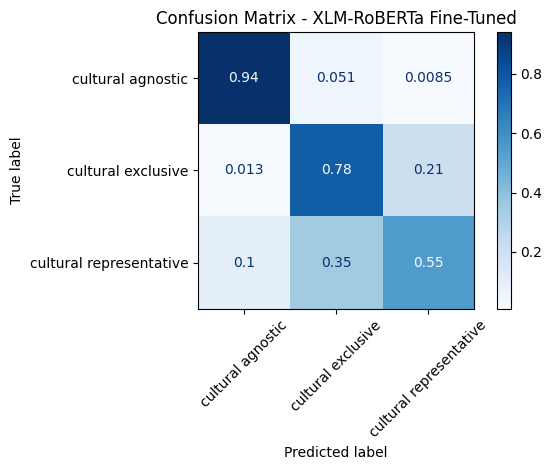

Model saved to: xlm_roberta_finetuned_custom


In [ ]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

for df in [train_df, test_df]:
    for col in ['text', 'description', 'name', 'type', 'subcategory', 'category']:
        df[col] = df[col].fillna('')

train_texts = (train_df['name'] + " - " + train_df['type'] + " - " + train_df['subcategory'] + " - " +
               train_df['category'] + " - " + train_df['description'] + " - " + train_df['text']).tolist()
test_texts = (test_df['name'] + " - " + test_df['type'] + " - " + test_df['subcategory'] + " - " +
              test_df['category'] + " - " + test_df['description'] + " - " + test_df['text']).tolist()

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df[LABEL_COLUMN])
test_labels = label_encoder.transform(test_df[LABEL_COLUMN])

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
train_encodings = tokenizer(train_texts, padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt")
test_encodings = tokenizer(test_texts, padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt")

train_dataset = TensorDataset(train_encodings["input_ids"], train_encodings["attention_mask"], torch.tensor(train_labels))
test_dataset = TensorDataset(test_encodings["input_ids"], test_encodings["attention_mask"], torch.tensor(test_labels))

train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)

for name, param in model.base_model.encoder.named_parameters():
    if name.startswith("layer"):
        layer_num = int(name.split('.')[1])
        if layer_num < FREEZE_LAYERS:
            param.requires_grad = False

model.to(device)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for batch in loop:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} - Avg Loss: {total_loss / len(train_loader):.4f}")

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_, digits=4))

cm = confusion_matrix(all_labels, all_preds, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - XLM-RoBERTa Fine-Tuned")
plt.grid(False)
plt.tight_layout()
plt.show()

os.makedirs(MODEL_DIR, exist_ok=True)
model.save_pretrained(MODEL_DIR)
tokenizer.save_pretrained(MODEL_DIR)
torch.save(model.state_dict(), os.path.join(MODEL_DIR, "model_weights.pt"))
save_file(model.state_dict(), os.path.join(MODEL_DIR, "model.safetensors"))
print(f"Model saved to: {MODEL_DIR}")